In [1]:
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import yfinance as yf
import itertools
import math
from co import *
import ndtest
import random
from hurst import *


# Download SP500 tickers, set your trading dates, and calculate mean returns and volatility for trading period to be used as a feature vector

In [2]:
#sp500 ticker download
import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

x=save_sp500_tickers()

for i in range (0,len(x)):
    x[i]=x[i].replace('\n', '')
x.remove('BRK.B')
x.remove('BF.B')
x.remove('ZTS')
x.remove('ZION')
x.remove('ZBH')
x.remove('ZBRA')
x.remove('CEG')
x.remove('ALB')
asset_list=x

In [33]:
#Asset list
lst=asset_list

#dates for model calibration
start_data='2020-08-19'
end_data='2022-08-19'

#dates for trading with algo
start_trade='2022-08-01'
end_trade='2022-09-01'

index_comp='SPY'

# Length of trading period
from datetime import *

d1=datetime.strptime(start_trade, "%Y-%m-%d")
d2=datetime.strptime(end_trade, "%Y-%m-%d")
length_trade_period =(np.abs(d1-d2)).days


In [ ]:
#feature vectors for each asset
mean_ret_lst=[]
vol_lst=[]

feature_df = pd.DataFrame(columns=['mean return', 'volatility'])

for i in lst:
    x=yf.download(i, start=start_trade, end=end_trade, interval = "1d")
    x.ta.vwap(append=True).dropna()
    x['Log_Returns'] = np.log(x['VWAP_D']) - np.log(x['VWAP_D'].shift(1))
    x = x['Log_Returns'].fillna(0)

    # mean return of trading period
    mean_ret = x.mean()*length_trade_period
    mean_ret_lst.append

    #mean volatility (vwap) of trading period
    vol=x.std()*np.sqrt(length_trade_period)
    
    feature_df.loc[i]= [mean_ret, vol]


In [35]:
feature_df

,mean return,volatility
MMM,-0.183411,0.106008
AOS,-0.114167,0.081251
ABT,-0.077187,0.054397
ABBV,-0.057189,0.040779
ABMD,-0.149033,0.107534
...,...,...
GWW,0.023936,0.052480
WYNN,-0.045989,0.120341
XEL,0.027682,0.037318
XYL,0.003984,0.102714


# Distribution of features is not perfectly Gaussian with N(0,1) so we will standardise our data

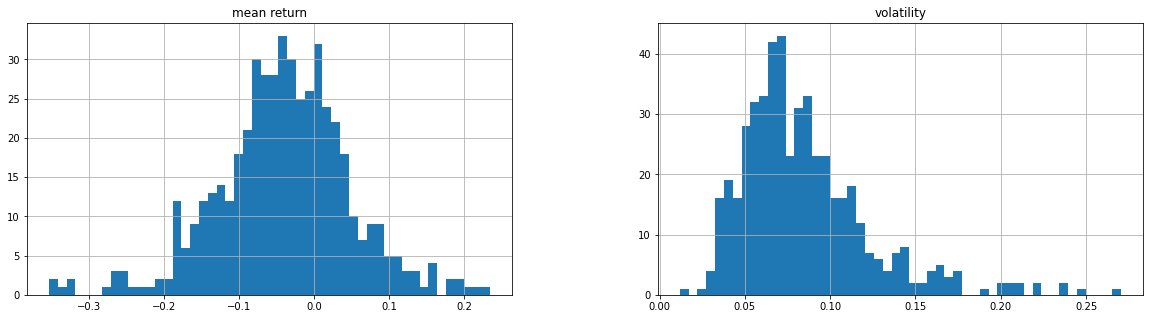

In [36]:
%matplotlib inline
feature_df.hist(bins=50, figsize=(20,5))
plt.show()

In [37]:
from sklearn.preprocessing import StandardScaler
feature_array=feature_df.values

scale=StandardScaler().fit(feature_array)

scale_feature_df=pd.DataFrame(scale.fit_transform(feature_array),
                              columns=feature_df.columns,
                              index=feature_df.index)
scale_feature_df


,mean return,volatility
MMM,-1.604715,0.558933
AOS,-0.823991,-0.092379
ABT,-0.407034,-0.798874
ABBV,-0.181557,-1.157153
ABMD,-1.217103,0.599084
...,...,...
GWW,0.733141,-0.849320
WYNN,-0.055275,0.936015
XEL,0.775381,-1.248209
XYL,0.508180,0.472268


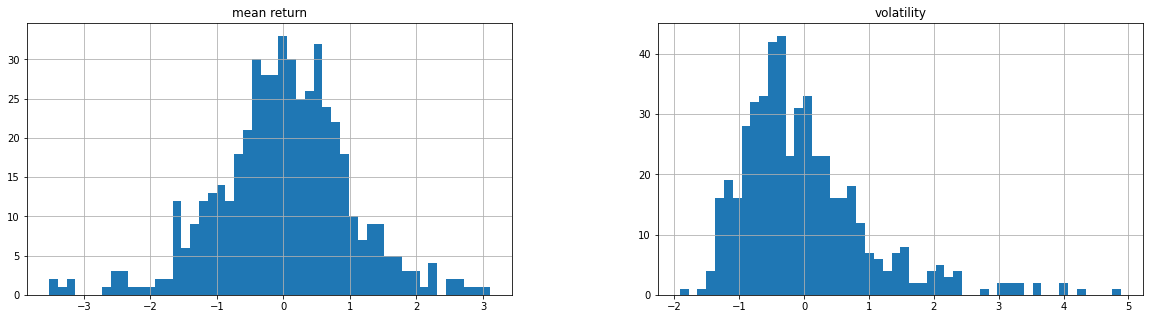

In [38]:
%matplotlib inline

scale_feature_df.hist(bins=50, figsize=(20,5))
plt.show()


# Find optimal number of clusters for hierarchical clustering using dendrogram
## Locate the space with the longest vertical lines and draw a horizontal line through this
## Count how many times this horizontal line intersects with the vertical lines
## Number of intersections = number of clusters = 5

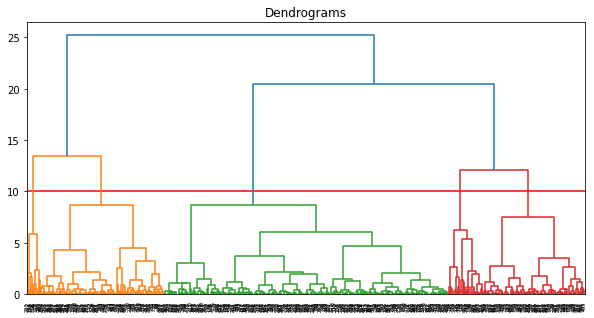

In [171]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 5))  
plt.title("Dendrograms") 
plt.axhline(y = 10, color = 'r', linestyle = '-')

dend = shc.dendrogram(shc.linkage(scale_feature_df, method='ward'))


# Run Hierarchical Clustering model from sk learn using ward as the linkage parameter

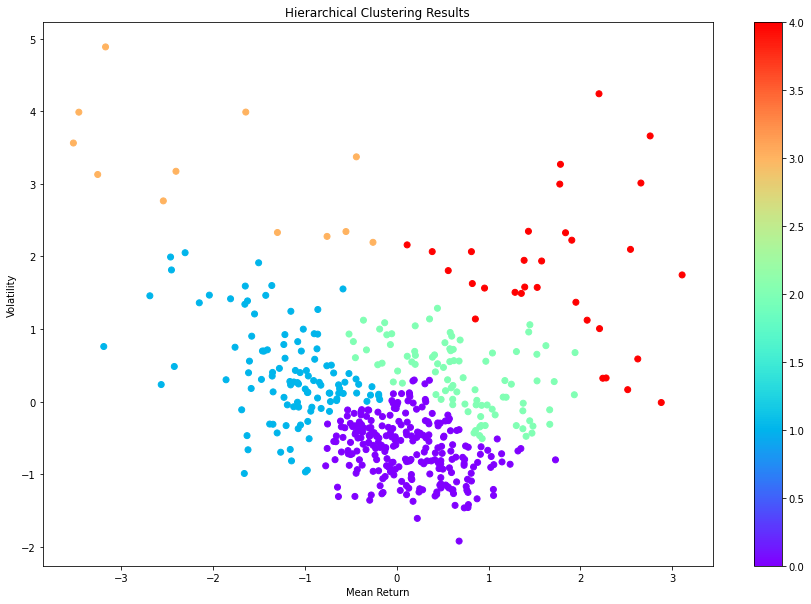

In [176]:
#Fit the model
clusters = 5
hc = AgglomerativeClustering(n_clusters= clusters, affinity='euclidean', linkage='ward')
labels = hc.fit_predict(scale_feature_df)

#Plot the results
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(scale_feature_df.iloc[:,0], scale_feature_df.iloc[:,1], c=labels, cmap='rainbow')
ax.set_title('Hierarchical Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

In [188]:
feature_df['labels']=labels
feature_df['labels'] = feature_df['labels'].astype("category")
feature_df.sort_values(by=['labels'])

,mean return,volatility,labels
DPZ,-0.059315,0.079321,0
EVRG,0.013700,0.036691,0
ES,0.016680,0.042824,0
EXC,-0.057062,0.060854,0
EXPD,-0.041718,0.081190,0
...,...,...,...
EOG,0.154724,0.123014,4
EPAM,0.234475,0.151110,4
APA,0.116325,0.198638,4
FANG,0.079202,0.141449,4


## Break the features data frame into seperate dataframes for each cluster, and pick the cluster with highest vol and lowest mean return to run through copula algo

In [190]:
cluster_list=np.arange(0,clusters,1)
cluster_list
d = {}
for c in cluster_list:
    d[c] = pd.DataFrame()
    d[c] = feature_df[feature_df['labels'] ==c]

In [191]:
d

{0:       mean return  volatility labels
 ABT     -0.077187    0.054397      0
 ABBV    -0.057189    0.040779      0
 ACN     -0.061572    0.060347      0
 ATVI    -0.021296    0.023720      0
 ADM      0.060132    0.057543      0
 ...           ...         ...    ...
 WY      -0.091272    0.071149      0
 WMB      0.008214    0.077787      0
 WTW      0.015942    0.055754      0
 GWW      0.023936    0.052480      0
 XEL      0.027682    0.037318      0
 
 [253 rows x 3 columns],
 1:       mean return  volatility labels
 MMM     -0.183411    0.106008      1
 AOS     -0.114167    0.081251      1
 ABMD    -0.149033    0.107534      1
 ADBE    -0.121400    0.095832      1
 AAP     -0.187854    0.135775      1
 ...           ...         ...    ...
 WELL    -0.153256    0.058350      1
 WST     -0.185746    0.067027      1
 WDC     -0.201655    0.138626      1
 WHR     -0.137029    0.094779      1
 YUM     -0.129340    0.048028      1
 
 [109 rows x 3 columns],
 2:       mean return  volat

In [192]:
d_scale = {}
for c in cluster_list:
    d_scale[c] = pd.DataFrame()
    d_scale[c] = scale_feature_df[feature_df['labels'] ==c]

mean_list=[]
vol_list=[]
for i in cluster_list:
    mean_list.append(d_scale[i]['mean return'].mean())
    vol_list.append(d_scale[i]['volatility'].mean())
center_list=list(zip(mean_list,vol_list,cluster_list))

def sort_tuple(tup):
    tup.sort(key = lambda x: x[1])
    return tup
center_list=sort_tuple(center_list)

In [193]:
center_list[-2]

(1.7357915046718384, 1.78279896966777, 4)

In [194]:
asset_dict = {}
for a in cluster_list:
    asset_dict[a] = d[a].index.tolist()
asset_dict[center_list[-1][2]]

['APTV',
 'BALL',
 'CZR',
 'DXC',
 'FTNT',
 'ILMN',
 'MTCH',
 'MRNA',
 'PENN',
 'PVH',
 'SEDG',
 'WBD']

In [ ]:
h=Hurst()
hurst_returns=h.get_hurst_return(asset_dict[center_list[-1][2]] ,start_data,end_data,start_trade,end_trade,int(len(asset_dict[center_list[-1][2]])/2))
hurst_returns

## Returns using hierarchical clustering to pick basket of assets and hurst exponent to find optimal pairs for trading within said basket

In [197]:
index_price = yf.download(index_comp, start=start_trade, end=end_trade)
index_price = index_price['Adj Close']
index_ret = index_price.pct_change().dropna()

metrics= pd.DataFrame(index=['Algo-Hierarchical'], columns=['Total return', 'APR', 'Sharpe', 'Max Drawdown', 'Max Drawdown Duration'])
metrics.loc['Algo-Hierarchical'] =h.metrics_calc(np.nancumprod(hurst_returns + 1))

metrics.loc['Index']=h.metrics_calc(np.nancumprod(index_ret + 1))
metrics


[*********************100%***********************]  1 of 1 completed


,Total return,APR,Sharpe,Max Drawdown,Max Drawdown Duration
Algo-Hierarchical,0.05511,0.848685,3.549648,0.0,0.0
Index,-0.031564,-0.307454,-1.855595,-0.080335,11.0


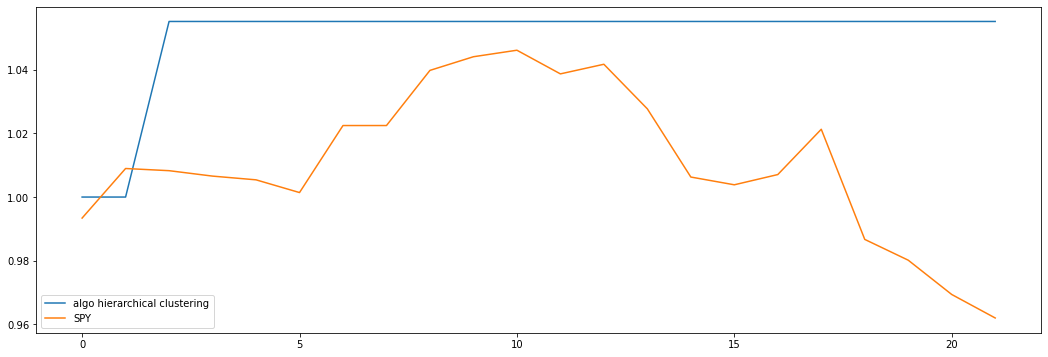

In [198]:
plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(hurst_returns + 1), label='algo hierarchical clustering')
plt.plot(np.nancumprod(index_ret + 1), label=index_comp)
plt.legend()

## Run hierarchical clustering algo using different linkage parameters and calculate returns in the same manner as above. 
* Note: 'ward' probably makes the most sense

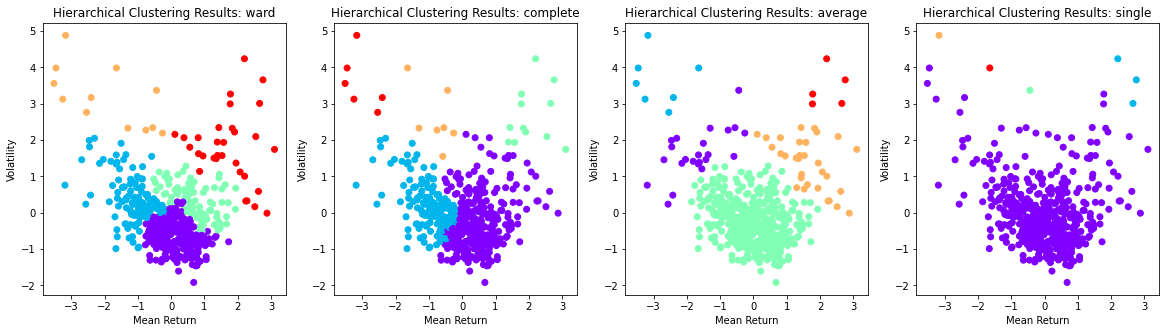

In [199]:
#Fit the model
clusters = 5
linkage_list=['ward', 'complete', 'average','single']
fig, ax = plt.subplots(1,4, figsize=(20,5))
for i in range(0,len(linkage_list)):
    hc = AgglomerativeClustering(n_clusters= clusters, affinity='euclidean', linkage=linkage_list[i])
    labels = hc.fit_predict(scale_feature_df)

    #Plot the results
    scatter = ax[i].scatter(scale_feature_df.iloc[:,0], scale_feature_df.iloc[:,1], c=labels, cmap='rainbow')
    ax[i].set_title('Hierarchical Clustering Results: '+linkage_list[i])
    ax[i].set_xlabel('Mean Return')
    ax[i].set_ylabel('Volatility')

In [ ]:
hi_list=['ward', 'complete', 'average']
l=[]
return_dict={}

for i in range(0,len(hi_list)):
    #Fit the model
    clusters = 4
    hc = AgglomerativeClustering(n_clusters= clusters, affinity='euclidean', linkage=hi_list[i])
    labels = hc.fit_predict(scale_feature_df)
    
    feature_df['labels']=labels
    feature_df['labels'] = feature_df['labels'].astype("category")
    feature_df.sort_values(by=['labels'])

    cluster_list=np.arange(0,4,1)
    cluster_list
    d = {}
    for c in cluster_list:
        d[c] = pd.DataFrame()
        d[c] = feature_df[feature_df['labels'] ==c]

    d_scale = {}
    for c in cluster_list:
        d_scale[c] = pd.DataFrame()
        d_scale[c] = scale_feature_df[feature_df['labels'] ==c]

    mean_list=[]
    vol_list=[]
    for i in cluster_list:
        mean_list.append(d_scale[i]['mean return'].mean())
        vol_list.append(d_scale[i]['volatility'].mean())
    center_list=list(zip(mean_list,vol_list,cluster_list))

    def sort_tuple(tup):
        tup.sort(key = lambda x: x[1])
        return tup
    center_list=sort_tuple(center_list)


    asset_dict = {}
    for a in cluster_list:
        asset_dict[a] = d[a].index.tolist()
    asset_dict[center_list[-1][2]]

    h=Hurst()
    hurst_returns=h.get_hurst_return(asset_dict[center_list[-1][2]] ,start_data,end_data,start_trade,end_trade,int(len(asset_dict[center_list[-1][2]])/2))
    return_dict[i]=hurst_returns
    l.append(h.metrics_calc(np.nancumprod(hurst_returns + 1)))


In [202]:
metrics= pd.DataFrame(index=['Hierarchical-ward'], columns=['Total return', 'APR', 'Sharpe', 'Max Drawdown', 'Max Drawdown Duration'])
metrics.loc['Hierarchical-ward'] =l[0]
metrics.loc['Hierarchical-complete'] =l[1]
metrics.loc['Hierarchical-average'] =l[2]
metrics.loc['Index']=h.metrics_calc(np.nancumprod(index_ret + 1))
metrics

,Total return,APR,Sharpe,Max Drawdown,Max Drawdown Duration
Hierarchical-ward,0.05511,0.848685,3.549648,0.0,0.0
Hierarchical-complete,0.05511,0.848685,3.549648,0.0,0.0
Hierarchical-average,-0.007612,-0.083803,-3.549648,-0.007612,16.0
Index,-0.031564,-0.307454,-1.855595,-0.080335,11.0
